In [1]:
import cobra
from cobra.io import load_json_model, save_json_model
from cobra import Model, Reaction, Metabolite
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3

In [2]:
recon1 = load_json_model('../data/gems/RECON1.json')
icho = load_json_model('../data/gems/iCHOv1.json')
recon1_gene_dict = {gene.name: gene.id for gene in recon1.genes }
icho_gene_dict = {gene.name: gene.id for gene in icho.genes}
recon1_match = pd.read_csv('../data/blast_results/recon1_match.csv')
icho_match = pd.read_csv('../data/blast_results/icho_match.csv')

# Draft reconstruction

In [3]:
def get_gene_states(rxn, match_table):
    output={}
    for gene in list(rxn.genes):
        if gene.name in list(match_table['query']):
            output[gene.id]='True'
        else:
            output[gene.id]='False'
    return output
            
def gpr_to_boolean(gpr_rule, gene_states):
    for gene, state in gene_states.items():
        gpr_rule = gpr_rule.replace(gene, str(state))
    return eval(gpr_rule) 

In [4]:
genes_icho = list(np.unique(icho_match['query']))
# print(len(genes_icho))
genes_recon1 = list(np.unique(recon1_match['query']))
# print(len(genes_recon1 ))

rxns_icho, rxns_recon1 = [],[]
for g in genes_icho:
    for rxn in list( icho.genes.get_by_id( icho_gene_dict[g] ).reactions ):
        if gpr_to_boolean(rxn.gene_reaction_rule, get_gene_states(rxn, icho_match )):
            rxns_icho.append( rxn.id)
for g in genes_recon1:
    for rxn in list(recon1.genes.get_by_id( recon1_gene_dict[g] ).reactions ):
        if rxn.id in ['PPCOAOm','ACOAD1fm','ACOAD9m']:
            rxns_recon1.append(rxn.id) #special case
        elif gpr_to_boolean(rxn.gene_reaction_rule, get_gene_states(rxn, recon1_match )):
            rxns_recon1.append(rxn.id)
rxns_icho = list(set(rxns_icho)); rxns_recon1 = list(set(rxns_recon1))
print(len(rxns_icho))
print(len(rxns_recon1))

3131
2277


Text(0.5, 1.0, 'Automatic curation of reactions')

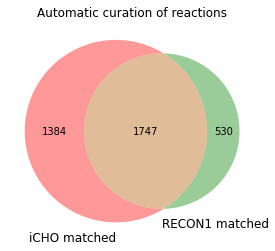

In [5]:
fig,ax = plt.subplots(1,1)
venn2([set(rxns_icho),set(rxns_recon1)],set_labels=['iCHO matched','RECON1 matched'], ax=ax)
ax.set_title('Automatic curation of reactions')

In [7]:
# ibt_draft = load_json_model('../data/gems/iBT_draft.json')
recon1_match['template_gene'] = [ recon1_gene_dict[gname] for gname in list(recon1_match['query'])]
icho_match['template_gene'] = [icho_gene_dict[gname] for gname in list(icho_match['query']) ]

def add_metabolite(model, template, met_id):
    all_mets = [met.id for met in model.metabolites]
    new_id = met_id.replace('_cho','_bt').replace('_hs','_bt')
    if new_id not in all_mets:
        temp_met = template.metabolites.get_by_id( met_id )
        model.add_metabolites([Metabolite(id=new_id, formula=temp_met.formula,
                charge=float(temp_met.charge),name=temp_met.name, compartment=temp_met.compartment)])
    return None

def translate_gpr(template_rule, homology_table):
    tokens = template_rule.split()  
    translated_rule = []
    for token in tokens:
        if token not in list(homology_table['template_gene']):
            translated_rule.append(token)
        elif list(homology_table['template_gene']).count(token) == 1:
            new_token = list(homology_table[homology_table['template_gene']==token]['subject'])[0]
            translated_rule.append(new_token)
        elif list(homology_table['template_gene']).count(token) > 1:
            new_tokens = list(homology_table[homology_table['template_gene']==token]['subject'])
            new_token = ' or '.join(new_tokens)
            translated_rule.append(new_token)
    return ' '.join(translated_rule)
    

def add_rxn(model, template, match_table, rxn_id):
    all_rxns = [rxn.id for rxn in model.reactions]
    new_id = rxn_id.replace('_cho','_bt').replace('_hs','_bt')
    if new_id not in all_rxns:
        temp_rxn = template.reactions.get_by_id( rxn_id )
        model.add_reactions([Reaction(id=new_id,name=temp_rxn.name,subsystem= temp_rxn.subsystem,
                lower_bound=temp_rxn.lower_bound,upper_bound=temp_rxn.upper_bound)])
        for met in (temp_rxn.reactants+temp_rxn.products):
            add_metabolite(model, template, met.id)
        rxn_string = str(temp_rxn.reaction).replace('_cho','_bt').replace('_hs','_bt')
        model.reactions.get_by_id(new_id).build_reaction_from_string(rxn_string)
        model.reactions.get_by_id(new_id).gene_reaction_rule = translate_gpr(temp_rxn.gene_reaction_rule, match_table)
    return None

In [9]:
# # add reactions from recon1
# for rxn_id in rxns_recon1:
#     add_rxn(ibt_draft, recon1, recon1_match, rxn_id)
    
# # add reactions from icho
# for rxn_id in list( set(rxns_icho) - set(rxns_recon1) ):
#     add_rxn(ibt_draft, icho, icho_match, rxn_id)

# Add boundary reactions

In [39]:
# ibt_draft = load_json_model('../data/gems/iBT_draft.json')

In [40]:
# for met in ibt_draft.metabolites.query('_e'):
#     if met.compartment == 'e':
#         rxn = Reaction(id='EX_'+met.id,name=met.name+' exchange',subsystem= 'Extracellular exchange',
#                 lower_bound=-1000.0,upper_bound=1000.0)
#         ibt_draft.add_reactions([rxn])
#         ibt_draft.reactions.get_by_id( 'EX_'+met.id ).build_reaction_from_string(met.id + ' <=> ')

In [48]:
# save_json_model(ibt_draft,'../data/gems/iBT_draft.json')

In [81]:
subsys_sum = {}
for rxn in set(ibt_draft.reactions) - set(ibt_draft.boundary):
    subsystem = rxn.subsystem
    if ('Transport' in subsystem) or ('TRANSPORT' in subsystem):
        continue
    if subsystem == '':
        subsystem = 'NaN'
    if subsystem not in subsys_sum.keys():
        subsys_sum[subsystem] = 1
    else:
        subsys_sum[subsystem] += 1   

In [86]:
sum_pd = pd.DataFrame( zip(subsys_sum.keys(), subsys_sum.values()) )
sum_pd  = sum_pd.sort_values(by=1,ascending=False).reset_index().drop(['index'],axis=1)
sum_top20 = sum_pd.iloc[:20]

Text(0.5, 1.0, 'Top 20 subsystems')

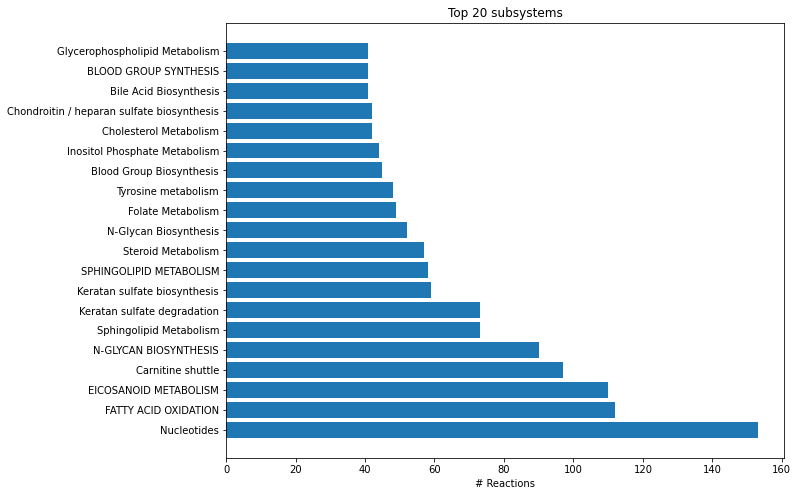

In [89]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.barh(sum_top20[0],sum_top20[1])
ax.set_xlabel('# Reactions')
ax.set_title('Top 20 subsystems')

# Gap fill with Recon1 model

In [49]:
ibt_draft = load_json_model('../data/gems/iBT_draft.json')

In [50]:
ibt_draft.objective.expression

1.0*BIOMASS_bt - 1.0*BIOMASS_bt_reverse_b3fbe

In [51]:
ibt_draft.slim_optimize()

0.0